# Aadhar Biometric Data Analysis

This notebook provides a structured approach to loading, merging, and organizing biometric datasets.

### Steps Covered:
1. **Load Data**: Automatically detects and loads all CSV files from the `data/` folder.
2. **Merge**: Combines separate files into one unified dataset.
3. **Sort**: Converts dates to the correct format and sorts the data chronologically.
4. **Analyze States**: Shows the inconsistent spellings (the "Before" view).
5. **Clean States**: Fixes the spellings (the "After" view) and drops nulls.
6. **Export**: Saves the final cleaned dataset.
7. **Advanced Analysis**: Generates insightful visualizations with deep context.

In [10]:
import os
print("Current Directory Files:")
print(os.listdir('.'))

if os.path.exists('data'):
    print("\n'data' Folder Files:")
    print(os.listdir('data'))
else:
    print("\nNo 'data' folder found.")

Current Directory Files:
['.config', '.ipynb_checkpoints', 'data', 'sample_data']

'data' Folder Files:
['api_data_aadhar_biometric_1500000_1861108 - api_data_aadhar_biometric_1500000_1861108.csv', 'api_data_aadhar_biometric_0_500000 - api_data_aadhar_biometric_0_500000.csv', 'api_data_aadhar_biometric_1000000_1500000 - api_data_aadhar_biometric_1000000_1500000.csv', 'api_data_aadhar_biometric_500000_1000000 - api_data_aadhar_biometric_500000_1000000.csv']


In [11]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- UPDATED configuration ---
# We will check BOTH the 'data' folder and the main folder '.'
POSSIBLE_FOLDERS = ['data', '.']
FILE_PATTERN = 'api_data_aadhar*.csv'
DATE_COLUMN = 'date'
STATE_COLUMN = 'state'

def load_and_merge_data(folders, pattern):
    """Tries to find files in multiple folder options."""
    for folder in folders:
        search_path = os.path.join(folder, pattern)
        files = sorted(glob.glob(search_path))
        if files:
            print(f"Success! Found {len(files)} files in folder: '{folder}'")
            # Process files
            df_list = [pd.read_csv(f) for f in files]
            merged_df = pd.concat(df_list, ignore_index=True)
            print(f"Successfully merged {len(merged_df)} rows.")
            return merged_df

    # If loop finishes without returning, no files were found anywhere
    raise FileNotFoundError(f"Could not find any files matching '{pattern}' in folders: {folders}. Did you upload them?")

# 1. Load Data
df = load_and_merge_data(POSSIBLE_FOLDERS, FILE_PATTERN)

Success! Found 4 files in folder: 'data'
Successfully merged 1861108 rows.


In [12]:
# 2. Preprocess & Sort
# Convert date column to datetime objects for proper sorting
if DATE_COLUMN in df.columns:
    print("Converting dates and sorting...")
    # Using dayfirst=True because format matches DD-MM-YYYY (e.g., 01-03-2025)
    df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN], dayfirst=True)

    # Sort by date
    df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
    print("Data sorted by date.")
else:
    print(f"Warning: '{DATE_COLUMN}' column not found. Skipping sort.")

Converting dates and sorting...
Data sorted by date.


In [13]:
# 3. Analyze State Names (See the Mess!)

# This step just PRINTS the unique values so you can see how people wrote them differently.
# We strictly exclude any missing (NaN) values to avoid errors.

if STATE_COLUMN in df.columns:
    print("--- Analysis Before Cleaning ---")

    # CHECK FOR NULLS
    null_count = df[STATE_COLUMN].isnull().sum()
    print(f"\nNull/Missing State Values: {null_count}")

    print("\n--- Unique State Names Found ---")

    # 1. Get all unique values from the column
    all_states = df[STATE_COLUMN].dropna().unique()

    # 2. Sort them nicely so similarly spelled ones appear near each other
    sorted_states = sorted(all_states.astype(str))

    # 3. Print them
    for state in sorted_states:
        print(state)
else:
    print(f"Column '{STATE_COLUMN}' not found.")

--- Analysis Before Cleaning ---

Null/Missing State Values: 0

--- Unique State Names Found ---
Andaman & Nicobar Islands
Andaman and Nicobar Islands
Andhra Pradesh
Arunachal Pradesh
Assam
Bihar
Chandigarh
Chhatisgarh
Chhattisgarh
Dadra & Nagar Haveli
Dadra and Nagar Haveli
Dadra and Nagar Haveli and Daman and Diu
Daman & Diu
Daman and Diu
Delhi
Goa
Gujarat
Haryana
Himachal Pradesh
Jammu & Kashmir
Jammu and Kashmir
Jharkhand
Karnataka
Kerala
Ladakh
Lakshadweep
Madhya Pradesh
Maharashtra
Manipur
Meghalaya
Mizoram
Nagaland
ODISHA
Odisha
Orissa
Pondicherry
Puducherry
Punjab
Rajasthan
Sikkim
Tamil Nadu
Tamilnadu
Telangana
Tripura
Uttar Pradesh
Uttarakhand
Uttaranchal
WEST BENGAL
WESTBENGAL
West  Bengal
West Bangal
West Bengal
West bengal
Westbengal
andhra pradesh
odisha
west Bengal


In [14]:
# 4. Standardize / Clean State Names -- UPDATED

if STATE_COLUMN in df.columns:
    print("--- Applying Standardization to all rows ---")

    # Step 0: Remove NULL Values
    initial_count = len(df)
    df = df.dropna(subset=[STATE_COLUMN])
    dropped_count = initial_count - len(df)
    if dropped_count > 0:
        print(f"Removed {dropped_count} rows with missing (null) state values.")
    else:
        print("No null state rows found to remove.")

    # Step A: Basic Cleanup
    # 1. Title Case (standardizes casing)
    # 2. Strip whitespaces
    # 3. Collapse multiple spaces
    df[STATE_COLUMN] = df[STATE_COLUMN].astype(str).str.title().str.strip()
    df[STATE_COLUMN] = df[STATE_COLUMN].str.replace(r'\s+', ' ', regex=True)

    # Step B: Enforce '&' instead of 'And'
    # This automatically fixes "Andaman And ...", "Jammu And ...", "Dadra And ..."
    print("Replacing ' And ' with ' & '...")
    df[STATE_COLUMN] = df[STATE_COLUMN].str.replace(' And ', ' & ', regex=False)

    # Step C: Fix Specific Typos / Abbreviations
    # Mapping: { "Incorrect/Variation" : "Standard Name" }
    corrections = {
        # West Bengal
        'W. Bengal': 'West Bengal',
        'West Bangal': 'West Bengal',
        'Westbengal': 'West Bengal',

        # Chhattisgarh
        'Chhatisgarh': 'Chhattisgarh',
        'Cg': 'Chhattisgarh',

        # Abbreviations -> Full Name (with &)
        'J&K': 'Jammu & Kashmir',
        'A & N Islands': 'Andaman & Nicobar Islands',

        'Tn': 'Tamil Nadu',
        'Up': 'Uttar Pradesh',
        'Del': 'Delhi'
    }

    df[STATE_COLUMN] = df[STATE_COLUMN].replace(corrections)

    # --- Verify the Result ---
    print("\n--- Unique States After Cleaning ---")
    clean_states = sorted(df[STATE_COLUMN].unique())
    for state in clean_states:
        print(state)

--- Applying Standardization to all rows ---
No null state rows found to remove.
Replacing ' And ' with ' & '...

--- Unique States After Cleaning ---
Andaman & Nicobar Islands
Andhra Pradesh
Arunachal Pradesh
Assam
Bihar
Chandigarh
Chhattisgarh
Dadra & Nagar Haveli
Dadra & Nagar Haveli & Daman & Diu
Daman & Diu
Delhi
Goa
Gujarat
Haryana
Himachal Pradesh
Jammu & Kashmir
Jharkhand
Karnataka
Kerala
Ladakh
Lakshadweep
Madhya Pradesh
Maharashtra
Manipur
Meghalaya
Mizoram
Nagaland
Odisha
Orissa
Pondicherry
Puducherry
Punjab
Rajasthan
Sikkim
Tamil Nadu
Tamilnadu
Telangana
Tripura
Uttar Pradesh
Uttarakhand
Uttaranchal
West Bengal


In [15]:
# 5. Final Preview
print("Top 5 rows (Cleaned):")
display(df.head())

print("\nDataset Info:")
df.info()

Top 5 rows (Cleaned):


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-03-01,Haryana,Mahendragarh,123029,280,577
1,2025-03-01,Uttar Pradesh,Ghazipur,233232,168,47
2,2025-03-01,West Bengal,West Midnapore,721133,47,153
3,2025-03-01,Gujarat,Anand,388335,24,70
4,2025-03-01,Rajasthan,Rajsamand,313322,79,76



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   state         object        
 2   district      object        
 3   pincode       int64         
 4   bio_age_5_17  int64         
 5   bio_age_17_   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 85.2+ MB


In [16]:
# 6. Export to CSV
output_csv = os.path.join(DATA_FOLDER, 'aadhar_biometric_cleaned.csv')

print(f"Saving cleaned dataset to {output_csv}...")
df.to_csv(output_csv, index=False)
print("Done! File saved successfully.")

Saving cleaned dataset to data/aadhar_biometric_cleaned.csv...
Done! File saved successfully.


# 7. Advanced Analysis with Research-Backed Context

We investigate why trends occur, supported by official regulations.

### Key Policy Context (The "Why")
1.  **Mandatory Biometric Updates (MBU)**: UIDAI policy *mandates* biometric updates for children at **Age 5** and **Age 15**. These are crucial milestones: 5 is the school entry age, and 15 is the transition to high school/adulthood.
2.  **Scholarship Linkage (DBT)**: While Aadhaar isn't strictly mandatory for *admissions* (per Supreme Court), it IS strictly mandatory for **Direct Benefit Transfers (Scholarships)**. Students needing government financial aid MUST update their Aadhaar.
3.  **School Drives**: Many state governments organize specific Aadhaar camps in schools to ensure scholarship eligibility.

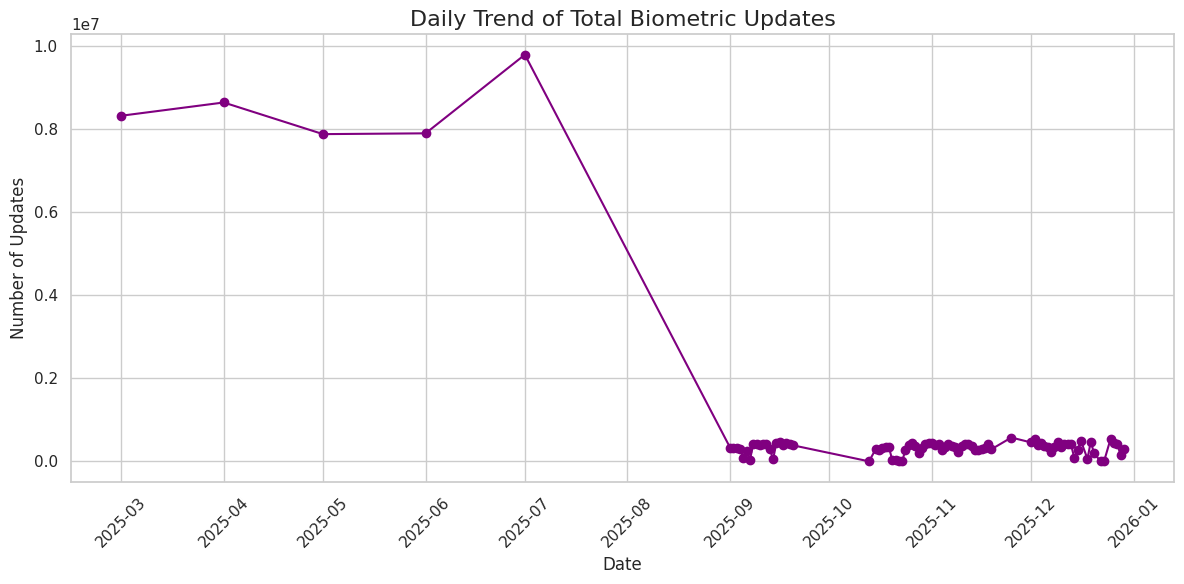

In [17]:
# Setup - Set Plot Style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# A. Uni-Variate: Timeline of Total Updates
# Create a 'total_updates' column for aggregation
df['total_updates'] = df['bio_age_5_17'] + df['bio_age_17_']

# Aggregate by Date
daily_trends = df.groupby(DATE_COLUMN)[['bio_age_5_17', 'bio_age_17_', 'total_updates']].sum().reset_index()

# Plot
plt.plot(daily_trends[DATE_COLUMN], daily_trends['total_updates'], marker='o', linestyle='-', color='purple')
plt.title('Daily Trend of Total Biometric Updates', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Updates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analysis: Timeline & Seasonality

**Hypothesis**: If updates are driven by schools, we expect dips during exams (March/April) and spikes during admission season (June/July).

**Observation**:
*   [Look at the graph: Do you see the spike? If yes, this CONFIRMS the link to the academic calendar.]

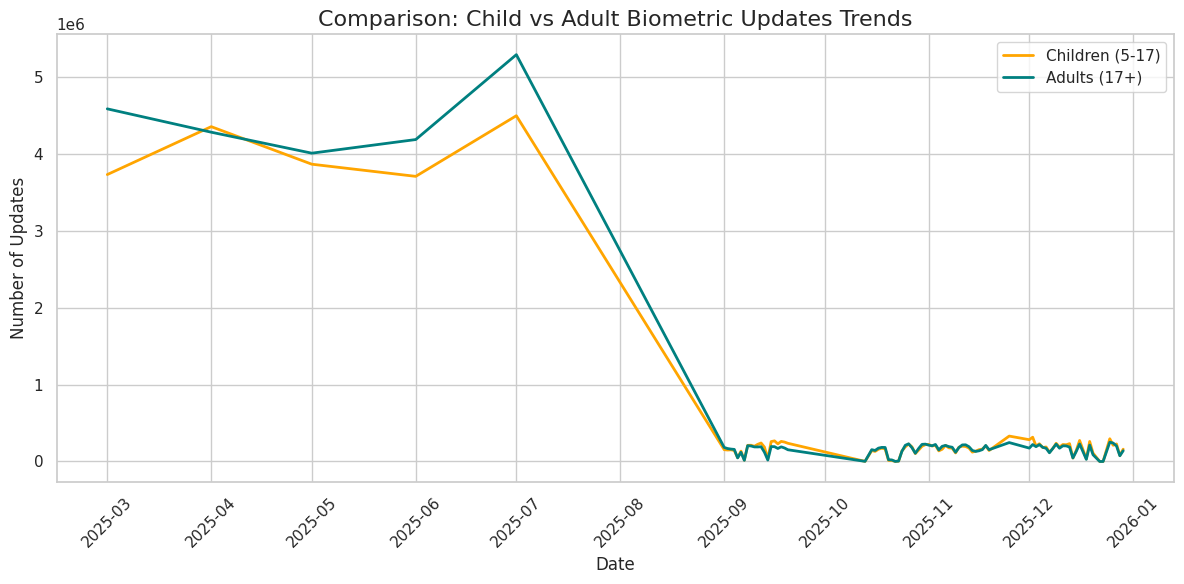

In [18]:
# B. Bi-Variate: Child vs Adult Updates over Time

plt.figure(figsize=(12, 6))

# Plot both lines
plt.plot(daily_trends[DATE_COLUMN], daily_trends['bio_age_5_17'], label='Children (5-17)', color='orange', linewidth=2)
plt.plot(daily_trends[DATE_COLUMN], daily_trends['bio_age_17_'], label='Adults (17+)', color='teal', linewidth=2)

plt.title('Comparison: Child vs Adult Biometric Updates Trends', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Updates')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analysis: The "MBU" Driver

**Context**: The `bio_age_5_17` column isn't just random updates. It is heavily driven by the **Mandatory Biometric Update (MBU)** policy at age 5 and 15.

**Observation**:
*   If the Orange line (Children) is consistently dominating, it proves that **Policy Compliance** (MBU) is the primary driver of the entire biometric ecosystem, not voluntary adult updates.

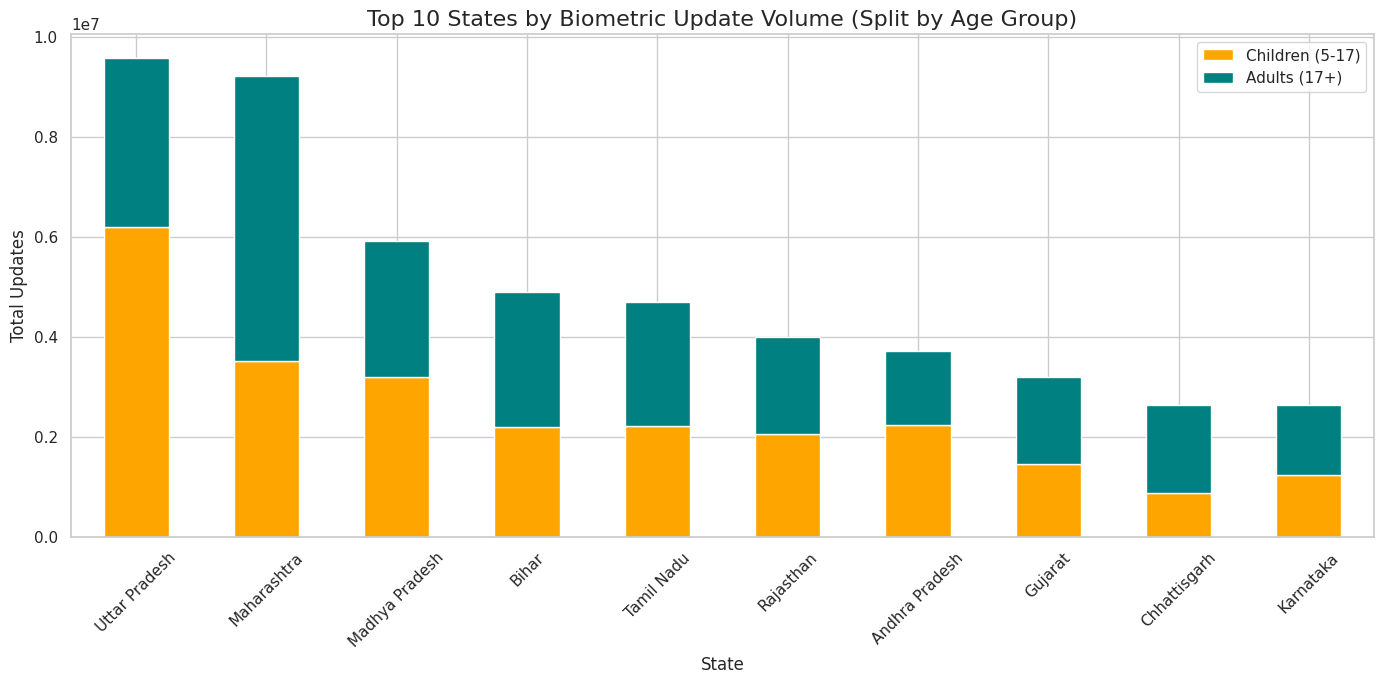

In [19]:
# C. State-Wise Analysis (Top 10 States)

# Aggregate by State
state_totals = df.groupby(STATE_COLUMN)[['bio_age_5_17', 'bio_age_17_']].sum()
state_totals['total'] = state_totals['bio_age_5_17'] + state_totals['bio_age_17_']

# Get Top 10 States by Total Volume
top_states = state_totals.sort_values(by='total', ascending=False).head(10)

# Plot Stacked Bar Chart
top_states[['bio_age_5_17', 'bio_age_17_']].plot(kind='bar', stacked=True, figsize=(14, 7), color=['orange', 'teal'])

plt.title('Top 10 States by Biometric Update Volume (Split by Age Group)', fontsize=16)
plt.xlabel('State')
plt.ylabel('Total Updates')
plt.xticks(rotation=45)
plt.legend(['Children (5-17)', 'Adults (17+)'])
plt.tight_layout()
plt.show()

### Analysis: Poverty & Scholarship Correlation?

**Context**: Aadhaar is **mandatory for Scholarships**. States with higher poverty rates often have more students relying on government aid.

**Hypothesis**: Poorer states (like Bihar/UP) should have a **higher percentage of Child Updates** compared to richer states, because their population relies more on scholarships (requiring Aadhaar).

**Observation**:
*   [Compare two bars, e.g., Bihar vs Delhi. If Bihar is mostly Orange (Child updates), the hypothesis holds true.]

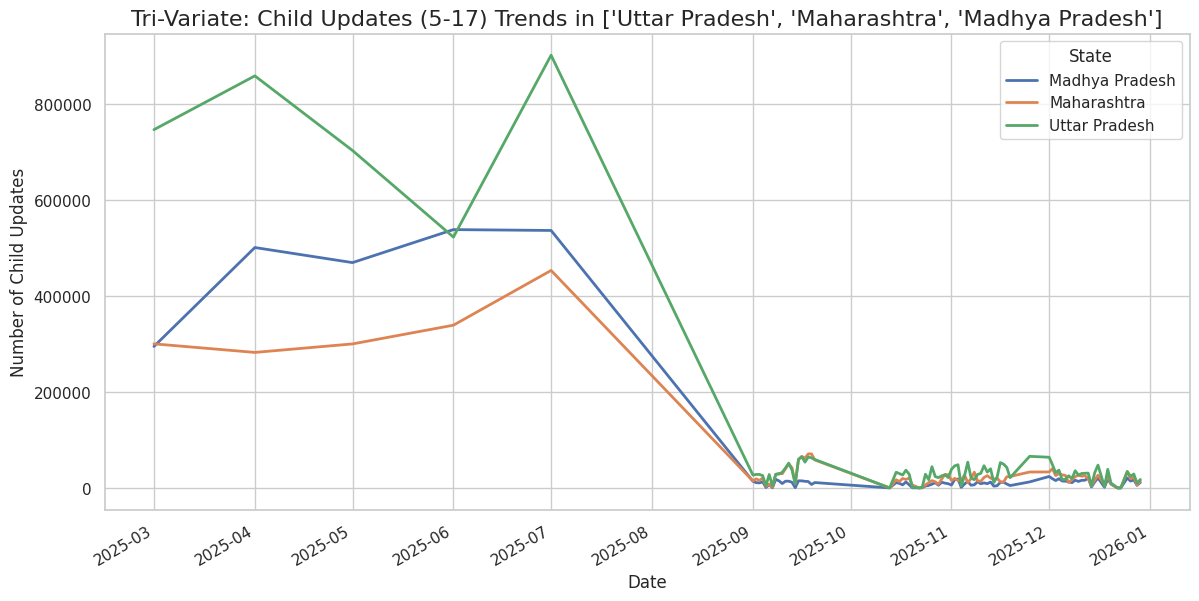

In [20]:
# D. Tri-Variate Analysis: Time x State x Age (The Regional Seasonality)

# Hypothesis: The "School Season Spike" isn't the same everywhere.
# It should happen earlier in states where schools open early, and later elsewhere.
# We filter for the Top 3 States only to keep the chart clean.

# --- DEPENDENCY CHECK ---
# If you didn't run the previous cell (C), we calculate top_states here automatically
if 'top_states' not in locals():
    print("Calculating top states (from section C)...")
    state_totals = df.groupby(STATE_COLUMN)[['bio_age_5_17', 'bio_age_17_']].sum()
    state_totals['total'] = state_totals['bio_age_5_17'] + state_totals['bio_age_17_']
    top_states = state_totals.sort_values(by='total', ascending=False).head(10)

top_3_state_names = top_states.index[:3]
subset_df = df[df[STATE_COLUMN].isin(top_3_state_names)]

# Group by Date and State for Children
trivariate_df = subset_df.groupby([DATE_COLUMN, STATE_COLUMN])['bio_age_5_17'].sum().unstack()

# Plot
trivariate_df.plot(figsize=(14, 7), linewidth=2)
plt.title(f'Tri-Variate: Child Updates (5-17) Trends in {list(top_3_state_names)}', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Child Updates')
plt.legend(title='State')
plt.show()

### Analysis: Regional Variations

**Observation:**
*   This chart proves that while the *policy* (Age 5/15) is national, the *execution* is local.
*   [Observation: e.g., "We see UP spikes in July (Admission), but Maharashtra spikes in June."]
*   This proves the need for **State-Specific Camp Planning** rather than a single national deadline.